<a href="https://colab.research.google.com/github/byildiz/ReplicationOfBatchNormalization/blob/master/ReproductionOfBatchNormalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Replication of Batch Normalization

In this notebook, some of the results of the original Batch Normalization[1] [paper](https://arxiv.org/pdf/1502.03167.pdf) is replicated in PyTorch.

[1] Ioffe, Sergey, and Christian Szegedy. "Batch normalization: Accelerating deep network training by reducing internal covariate shift." arXiv preprint arXiv:1502.03167 (2015).

## Settings

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
from torchvision import datasets
from torchsummary import summary
import matplotlib.pyplot as plt

In [0]:
# training settings
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# torch.manual_seed(123)

## Network

Below the network described in *Section 4.1* in the paper is created to replicate the results of *Figure 1*.

In [0]:
class SimpleNet(nn.Module):
  def __init__(self, withBN=False):
    super(SimpleNet, self).__init__()

    self.withBN = withBN

    self.fc1 = nn.Linear(28*28, 100)
    self.fc2 = nn.Linear(100, 100)
    self.fc3 = nn.Linear(100, 100)
    self.fc4 = nn.Linear(100, 10)
    
    if withBN:
      self.bn1 = nn.BatchNorm1d(100)
      self.bn2 = nn.BatchNorm1d(100)
      self.bn3 = nn.BatchNorm1d(100)

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)

    # first hidden
    x = self.fc1(x)
    if self.withBN:
      x = self.bn1(x)
    x = torch.sigmoid(x)

    # second hidden
    x = self.fc2(x)
    if self.withBN:
      x = self.bn2(x)
    x = torch.sigmoid(x)

    # third hidden
    x = self.fc3(x)
    if self.withBN:
      x = self.bn3(x)
    # for getting values for figure 1b and 1c
    self.inspect = x
    x = torch.sigmoid(x)
    
    # output
    output = self.fc4(x)
    return output

## Evaluation

In [0]:
def init_weight(m):
  if isinstance(m, nn.Linear):
    w = torch.randn(m.weight.data.size(), device=device)
    w.requires_grad = True
    m.weight.data = w


def test(model, device, test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  # 15th, 50th and 85th percentiles
  percentiles = [0, 0, 0]
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      # sum up batch loss
      test_loss += F.cross_entropy(output, target, reduction='sum').item()
      # get the index of the max log-probability
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()

      # percentiles of the input of last sigmoid
      percentile15, _ = torch.kthvalue(model.inspect, 15, dim=1)
      percentiles[0] += torch.mean(percentile15).item()
      percentile50, _ = torch.kthvalue(model.inspect, 50, dim=1)
      percentiles[1] += torch.mean(percentile50).item()
      percentile85, _ = torch.kthvalue(model.inspect, 85, dim=1)
      percentiles[2] += torch.mean(percentile85).item()

  test_loss /= len(test_loader.dataset)
  test_acc = correct / len(test_loader.dataset)
  percentiles = [p/len(test_loader.dataset) for p in percentiles]

  # print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
  #   test_loss, correct, len(test_loader.dataset),
  #   100. * test_acc))
  return test_loss, test_acc, percentiles


def train(model, device, train_loader, test_loader, num_epoch=1):
  optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
  model.train()
  history = {'test_loss': [], 'test_acc': [], 'percentiles': []}
  for epoch in range(num_epoch):
    for batch_idx, (data, target) in enumerate(train_loader):
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      output = model(data)
      loss = F.cross_entropy(output, target)
      loss.backward()
      optimizer.step()
      if batch_idx % 100 == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch + 1, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))

        test_loss, test_acc, percentiles = test(model, device, test_loader)
        history['test_acc'].append(test_acc)
        history['percentiles'].append(percentiles)
  return history


def plot_percentiles(percentiles, title):
  percentile15 = []
  percentile50 = []
  percentile85 = []
  for p in percentiles:
    percentile15.append(p[0])
    percentile50.append(p[1])
    percentile85.append(p[2])
  x = list(range(len(percentile15)))
  plt.figure()
  plt.title(title)
  plt.plot(x, percentile15)
  plt.plot(x, percentile50)
  plt.plot(x, percentile85)
  plt.show()

## Load Data
In *Section 4.1*, the authors evaluate the network on MNIST dataset. Thus, MNIST dataset is prepared below.

In [0]:
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
  datasets.MNIST('../data', train=True, download=True, transform=T.Compose([
                    T.ToTensor(),
                    T.Normalize((0.1307,), (0.3081,)),
                  ])),
  batch_size=60, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
  datasets.MNIST('../data', train=False, transform=T.Compose([
                    T.ToTensor(),
                    T.Normalize((0.1307,), (0.3081,)),
                  ])),
  batch_size=60, shuffle=True, **kwargs)

## Train Models

PyTorch uses Kaiming initialization[2] by default but in the paper, the authors say that weights are initialized to small random Gaussian values. To do that a function is implemented in *Section Functions* above and it is applied to the models.

[2] He, Kaiming, et al. "Delving deep into rectifiers: Surpassing human-level performance on imagenet classification." Proceedings of the IEEE international conference on computer vision. 2015.

In [6]:
num_epoch = 5

print('Training network without BN:')
model = SimpleNet().to(device)
model.apply(init_weight)
summary(model, (1, 28, 28))
history = train(model, device, train_loader, test_loader, num_epoch=num_epoch)
print('\nTraining network with BN:')
model_bn = SimpleNet(withBN=True).to(device)
model_bn.apply(init_weight)
summary(model_bn, (1, 28, 28))
history_bn = train(model_bn, device, train_loader, test_loader, num_epoch=num_epoch)

Training network without BN:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]          78,500
            Linear-2                  [-1, 100]          10,100
            Linear-3                  [-1, 100]          10,100
            Linear-4                   [-1, 10]           1,010
Total params: 99,710
Trainable params: 99,710
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.38
Estimated Total Size (MB): 0.39
----------------------------------------------------------------
Train Epoch: 1 [0/60000 (0%)]	Loss: 8.375727
Train Epoch: 1 [6000/60000 (10%)]	Loss: 1.909937
Train Epoch: 1 [12000/60000 (20%)]	Loss: 1.278815
Train Epoch: 1 [18000/60000 (30%)]	Loss: 1.336196
Train Epoch: 1 [24000/60000 (40%)]	Loss: 1.057657
Train Epoch: 1 [30000/60000

## Plot Charts
Below the same charts in *Figure 1* in the paper are plotted for comparison.

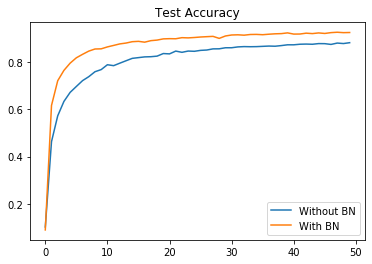

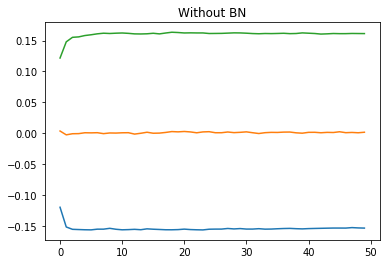

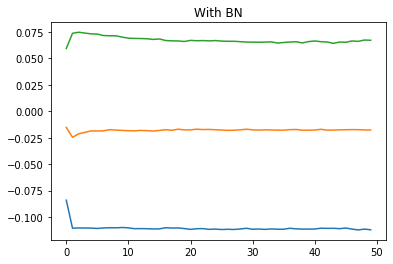

In [7]:
test_acc = history['test_acc']
test_acc_bn = history_bn['test_acc']
x = list(range(len(test_acc)))
plt.figure()
plt.title('Test Accuracy')
plt.plot(x, test_acc, label='Without BN')
plt.plot(x, test_acc_bn, label='With BN')
plt.legend()
plt.show()

plot_percentiles(history['percentiles'], 'Without BN')
plot_percentiles(history_bn['percentiles'], 'With BN')

## Conclusion
In short, the results given in *Figure 1* in *Section 4.1* is replicable.